# Oranges case

In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
from pathlib import Path
import sys

source_dir = str(Path.cwd().parent)
if source_dir not in sys.path:
    sys.path.append(source_dir)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import TimeSeriesSplit # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import itertools

pd.options.display.float_format = '{:,.2f}'.format

from oranges_case_lab.configs import config
from oranges_case_lab.constants import constants
 .utils import prophet_dataframe

ImportError: cannot import name 'prophet_dataframe' from 'oranges_case_lab.utils' (/Users/radimmusalek/Projects/Accenture_assignment/Oranges_case/oranges_case_lab/utils.py)

In [157]:
# loading both prices and GoogleData csv files
prices_orig = pd.read_csv(str(constants.DATASETS_DIR) + "/prices.csv")
google_orig = pd.read_csv(str(constants.DATASETS_DIR) + "/GoogleData_oranges.csv")

## Analysis of the datasets

### Data analysis - prices dataset

In [158]:
# overview of the prices dataset structure, its head
prices_orig.head()

Date  AveragePrice  TotalVolume       4046       4225      4770  \
0  2015-01-04          1.22    40,873.28   2,819.50  28,287.42     49.90   
1  2015-01-04          1.00   435,021.49 364,302.39  23,821.16     82.15   
2  2015-01-04           NaN   788,025.06  53,987.31 552,906.04 39,995.03   
3  2015-01-04          1.01    80,034.32  44,562.12  24,964.23  2,752.35   
4  2015-01-04          1.02   491,738.00   7,193.87 396,752.18    128.82   

   TotalBags  SmallBags  LargeBags  XLargeBags          type  year  \
0   9,716.46   9,186.93     529.53        0.00  conventional  2015   
1  46,815.79  16,707.15  30,108.64        0.00  conventional  2015   
2 141,136.68 137,146.07   3,990.61        0.00  conventional  2015   
3   7,755.62   6,064.30   1,691.32        0.00  conventional  2015   
4  87,663.13  87,406.84     256.29        0.00  conventional  2015   

                region  
0               Albany  
1              Atlanta  
2  BaltimoreWashington  
3                Boise  
4               Boston

In [159]:
# basic info of the prices dataset
prices_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25161 entries, 0 to 25160
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          25161 non-null  object 
 1   AveragePrice  24259 non-null  float64
 2   TotalVolume   24212 non-null  float64
 3   4046          24261 non-null  float64
 4   4225          24255 non-null  float64
 5   4770          24245 non-null  float64
 6   TotalBags     24271 non-null  float64
 7   SmallBags     24227 non-null  float64
 8   LargeBags     24214 non-null  float64
 9   XLargeBags    24293 non-null  float64
 10  type          25161 non-null  object 
 11  year          25161 non-null  int64  
 12  region        25161 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 2.5+ MB


In [160]:
# changing the datatype of the date column
prices_orig = prices_orig.astype({'Date': 'datetime64[ns]'})

In [161]:
# prices dataset overview
prices_orig.describe(include="all")

/Users/radimmusalek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



Date  AveragePrice   TotalVolume          4046  \
count                 25161     24,259.00     24,212.00     24,261.00   
unique                  233           NaN           NaN           NaN   
top     2016-10-23 00:00:00           NaN           NaN           NaN   
freq                    108           NaN           NaN           NaN   
first   2015-01-04 00:00:00           NaN           NaN           NaN   
last    2019-07-14 00:00:00           NaN           NaN           NaN   
mean                    NaN          1.40    917,091.34    298,153.02   
std                     NaN          0.38  3,731,937.46  1,288,583.40   
min                     NaN          0.44         84.56          0.00   
25%                     NaN          1.11     13,234.04        822.59   
50%                     NaN          1.36    119,052.77      9,855.11   
75%                     NaN          1.64    473,378.30    114,121.88   
max                     NaN          3.25 63,716,144.15 22,743,616.17   

                4225         4770     TotalBags     SmallBags    LargeBags  \
count      24,255.00    24,245.00     24,271.00     24,227.00    24,214.00   
unique           NaN          NaN           NaN           NaN          NaN   
top              NaN          NaN           NaN           NaN          NaN   
freq             NaN          NaN           NaN           NaN          NaN   
first            NaN          NaN           NaN           NaN          NaN   
last             NaN          NaN           NaN           NaN          NaN   
mean      295,828.43    22,463.62    295,043.21    212,419.88    75,899.24   
std     1,209,444.82   104,662.07  1,232,967.42    869,304.26   358,607.93   
min             0.00         0.00          0.00          0.00         0.00   
25%         3,061.14         0.00      7,319.51      4,770.44       235.82   
50%        26,977.55       193.76     46,257.71     31,337.34     4,043.68   
75%       149,871.91     6,078.17    139,429.54    100,882.73    30,503.37   
max    20,470,572.61 2,546,439.11 23,472,988.69 15,436,246.72 7,864,297.23   

        XLargeBags          type      year    region  
count    24,293.00         25161 25,161.00     25161  
unique         NaN             2       NaN        54  
top            NaN  conventional       NaN  Columbus  
freq           NaN         12582       NaN       466  
first          NaN           NaN       NaN       NaN  
last           NaN           NaN       NaN       NaN  
mean      4,405.64           NaN  2,016.78       NaN  
std      25,806.50           NaN      1.32       NaN  
min           0.00           NaN  2,015.00       NaN  
25%           0.00           NaN  2,016.00       NaN  
50%           0.00           NaN  2,017.00       NaN  
75%         313.89           NaN  2,018.00       NaN  
max     844,929.83           NaN  2,019.00       NaN

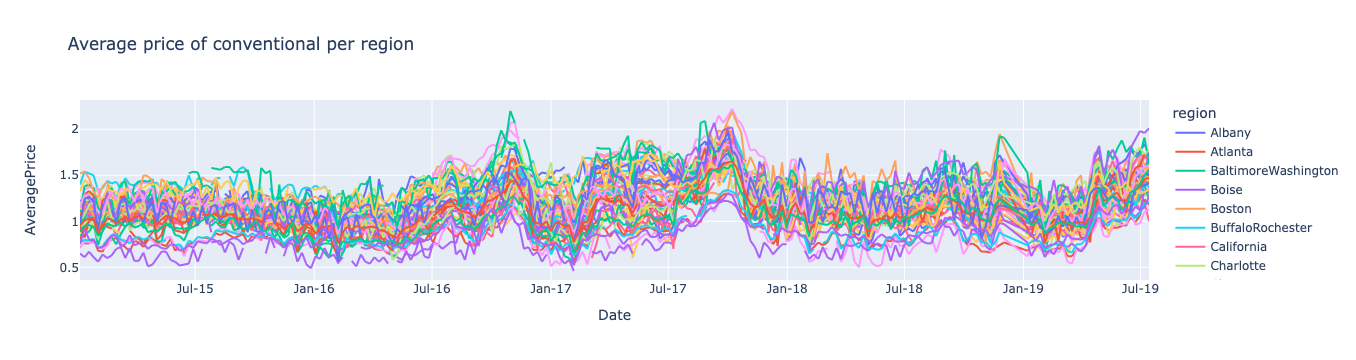

In [162]:
# interactive plot with conventional type prices per region over the time period
fig_pr_con = px.line(prices_orig[prices_orig["type"]=="conventional"],
                     x="Date", y="AveragePrice",
                     color="region", title='Average price of conventional per region')
fig_pr_con.update_xaxes(
    dtick="M6",
    tickformat="%b-%y")
fig_pr_con.show()

- Price spikes in the Oct-Nov period in the more recent years
- Significant increase in the recent months
- All regions seem to fit within approx. 1 USD range during the past

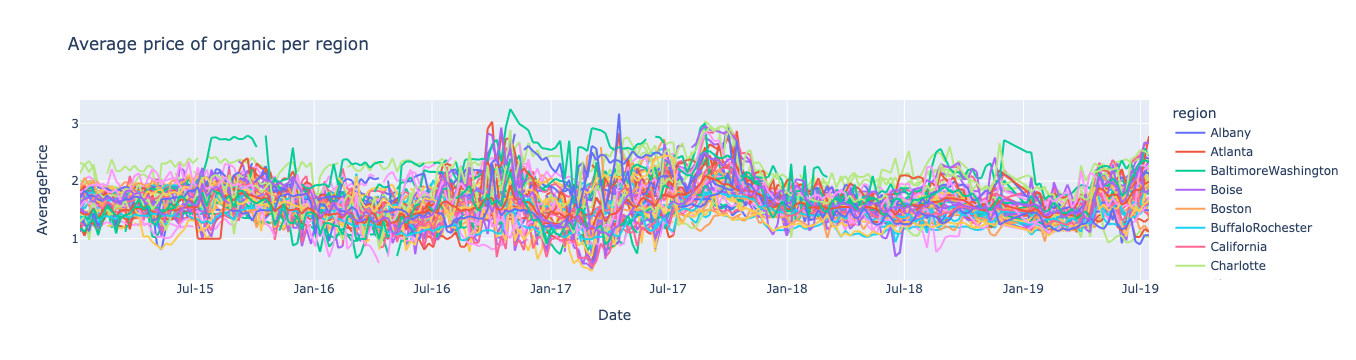

In [163]:
# interactive plot with organic type prices per region over the time period
fig_pr_org = px.line(prices_orig[prices_orig["type"]=="organic"],
                     x="Date", y="AveragePrice",
                     color="region", title='Average price of organic per region')
fig_pr_org.update_xaxes(
    dtick="M6",
    tickformat="%b-%y")
fig_pr_org.show()

- less structured than the price of conventional oranges
- San Francisco gets often high peaks which aren't followed in other regions
- it seems to be less seasonal driven than conventional orange prices

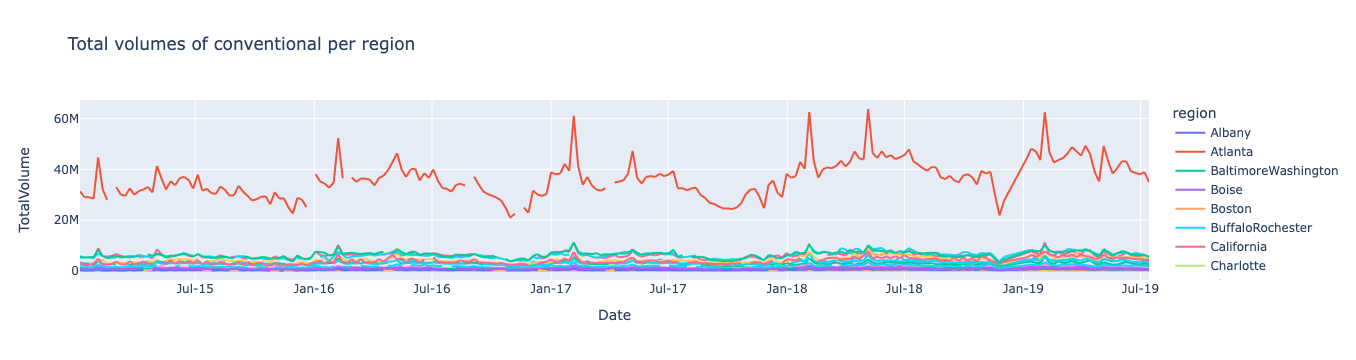

In [164]:
# interactive plot with conventional type volumes per region over the time period
fig_vol_con = px.line(prices_orig[prices_orig["type"]=="conventional"],
                      x="Date", y="TotalVolume",
                      color="region", title="Total volumes of conventional per region")
fig_vol_con.update_xaxes(
    dtick="M6",
    tickformat="%b-%y")
fig_vol_con.show()

- significant peaks in Feb and May across all major regions
- TotalUS is the biggest "region" so despite of the other regions are majority we should still include TotalUS in our models
- slight upward trend in total volumes

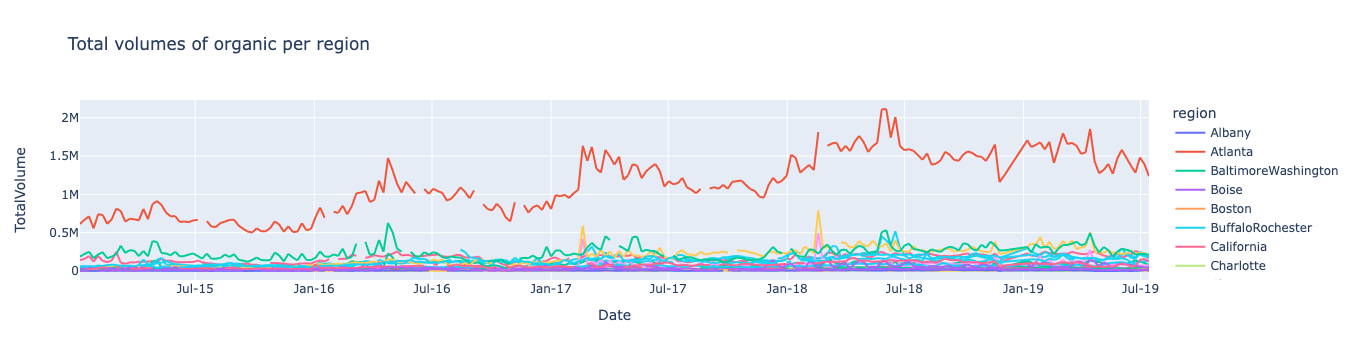

In [165]:
# interactive plot with organic type volumes per region over the time period
fig_vol_org = px.line(prices_orig[prices_orig["type"]=="organic"],
                      x="Date", y="TotalVolume",
                      color="region", title="Total volumes of organic per region")
fig_vol_org.update_xaxes(
    dtick="M6",
    tickformat="%b-%y")
fig_vol_org.show()

- magnitude smaller volumes than conventional oranges
- significant upward trend in the past, though flattened in 2019
- less pronounced seasonal trends
- similar to the conventional type, the TotalUS is the region with the largest volumes
- the whole US total volumes are driven mostly by a few regions (TotalUS, West, Northeast, New York, Great Lakes) and these regions aren't all the same as in the conventional type

### Data analysis - Google dataset

In [166]:
# overview of the Google dataset structure, its head
google_orig.head()

Unnamed: 0  oranges: (United States)  organic: (United States)  \
0  2015-01-04                        46                        76   
1  2015-01-11                        48                        79   
2  2015-01-18                        48                        82   
3  2015-01-25                        49                        82   
4  2015-02-01                        52                        81   

   oranges recipe: (United States)  oranges smoothie: (United States)  \
0                               84                                  8   
1                               76                                  8   
2                               84                                  9   
3                               89                                  8   
4                               82                                  7   

   oranges salad: (United States)  organic oranges: (United States)  
0                              51                                10  
1                              38                                29  
2                              66                                27  
3                              44                                28  
4                              46                                42

In [167]:
# basic info about the Google dataset
google_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Unnamed: 0                         239 non-null    object
 1   oranges: (United States)           239 non-null    int64 
 2   organic: (United States)           239 non-null    int64 
 3   oranges recipe: (United States)    239 non-null    int64 
 4   oranges smoothie: (United States)  239 non-null    int64 
 5   oranges salad: (United States)     239 non-null    int64 
 6   organic oranges: (United States)   239 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 13.2+ KB


In [168]:
# changing the datatype of the date column
google_orig = google_orig.astype({"Unnamed: 0": "datetime64[ns]"})

In [169]:
# Google dataset overview
google_orig.describe(include="all")

/Users/radimmusalek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



Unnamed: 0  oranges: (United States)  \
count                   239                    239.00   
unique                  239                       NaN   
top     2018-08-19 00:00:00                       NaN   
freq                      1                       NaN   
first   2015-01-04 00:00:00                       NaN   
last    2019-07-28 00:00:00                       NaN   
mean                    NaN                     52.31   
std                     NaN                     11.29   
min                     NaN                     29.00   
25%                     NaN                     44.50   
50%                     NaN                     52.00   
75%                     NaN                     60.00   
max                     NaN                    100.00   

        organic: (United States)  oranges recipe: (United States)  \
count                     239.00                           239.00   
unique                       NaN                              NaN   
top                          NaN                              NaN   
freq                         NaN                              NaN   
first                        NaN                              NaN   
last                         NaN                              NaN   
mean                       82.50                            66.99   
std                         6.85                            14.84   
min                        56.00                            33.00   
25%                        79.00                            55.00   
50%                        83.00                            68.00   
75%                        87.00                            78.50   
max                       100.00                           100.00   

        oranges smoothie: (United States)  oranges salad: (United States)  \
count                              239.00                          239.00   
unique                                NaN                             NaN   
top                                   NaN                             NaN   
freq                                  NaN                             NaN   
first                                 NaN                             NaN   
last                                  NaN                             NaN   
mean                                32.71                           50.18   
std                                 19.54                           12.26   
min                                  7.00                           15.00   
25%                                 15.00                           42.00   
50%                                 30.00                           50.00   
75%                                 50.50                           59.00   
max                                100.00                          100.00   

        organic oranges: (United States)  
count                             239.00  
unique                               NaN  
top                                  NaN  
freq                                 NaN  
first                                NaN  
last                                 NaN  
mean                               36.06  
std                                12.70  
min                                10.00  
25%                                27.00  
50%                                35.00  
75%                                44.50  
max                               100.00

In [170]:
# renaming the columns to get more readable format
google_orig.columns = ["Date", "oranges", "organic",
       "oranges recipe", "oranges smoothie",
       "oranges salad", "organic oranges"]

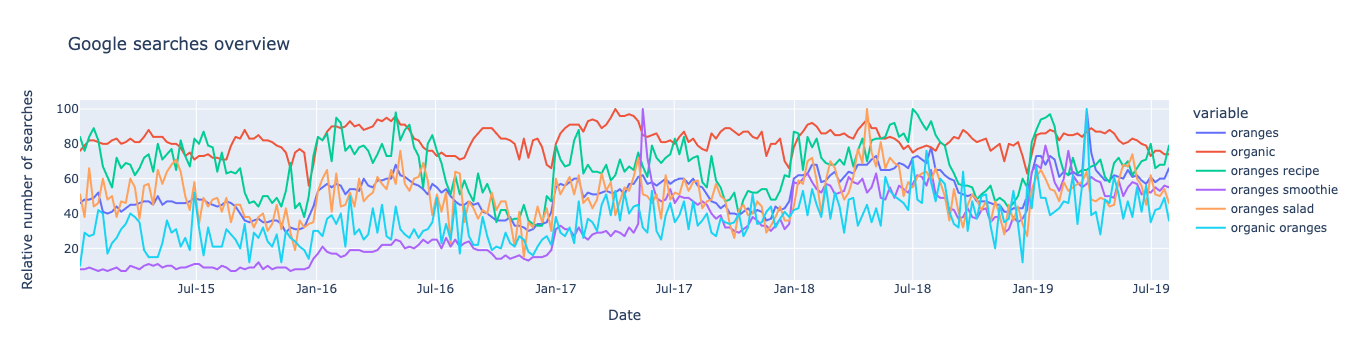

In [171]:
# interactive plot with G-searches per keyword over the time period
fig3 = px.line(google_orig, x="Date", y=google_orig.columns,
              title="Google searches overview", labels=dict(value="Relative number of searches"))
fig3.update_xaxes(
    dtick="M6",
    tickformat="%b-%y")
fig3.show()

- "oranges" search appears to be have seasonal trend with a significant drop from Sep till early Dec, one extraordinary peak in Mar-19
- "organic" search shows also seasonality trend with lows in Jun-Aug and Nov-Dec periods, hitting its lowest point regularly in Dec
- "oranges recipe" following similar trend to "orange", however with a greater week-to-week volatility
- "oranges smoothie" also shows minor seasonal trend with its lows in Q4s but with a clear upward trend since 2016
- "oranges salad" follow the "orange" search too (similarly to "orange recipe"), with a greater week-to-week volatility
- "organic oranges" doesn't seem to have a clear seasonality pattern, there's slight decrease in Q4 similar to the other searches, however, it's not as profound as in the other cases. On the other hand it shows high week-to-week volatility and a slight upward trend
- only "oranges" and "organic oranges" got the extraordinary peak in Mar-19 which doesn't show in the other searches

## Data cleaning and preprocessing

In [172]:
# split the prices dataset into organic and conventional type
prices_US_conv = prices_orig[prices_orig["type"]=="conventional"].reset_index(drop=True)
prices_US_org = prices_orig[prices_orig["type"]=="organic"].reset_index(drop=True)

In [173]:
# grouping the regional data of the conventional type oranges into whole US by Date
# AveragePrice is mean of its values, the other columns are summarised
prices_US_conv_group = prices_US_conv.groupby("Date").agg({"AveragePrice":"mean",
                                                           "TotalVolume":"sum",
                                                           "4046":"sum",
                                                           "4225":"sum",
                                                           "4770":"sum",
                                                           "TotalBags":"sum",
                                                           "SmallBags":"sum",
                                                           "LargeBags":"sum",
                                                           "XLargeBags":"sum"
                                                          }).reset_index()

In [174]:
# same process as above done for the organic oranges data
prices_US_org_group = prices_US_org.groupby("Date").agg({"AveragePrice":"mean",
                                                           "TotalVolume":"sum",
                                                           "4046":"sum",
                                                           "4225":"sum",
                                                           "4770":"sum",
                                                           "TotalBags":"sum",
                                                           "SmallBags":"sum",
                                                           "LargeBags":"sum",
                                                           "XLargeBags":"sum"
                                                          }).reset_index()

In [175]:
# merging of the both grouped data with the google searches data
# we keep all the columns of the google dataset for both merges
prices_US_conv_merged = prices_US_conv_group.merge(google_orig, how="left", on="Date")
prices_US_org_merged = prices_US_org_group.merge(google_orig, how="left", on="Date")

In [27]:
# left join is used as the most significant parameters for the prediction will be the price and volumes
# since those are the ones we're interested in for our model

In [28]:
# one missing date for G-searches, no need to extrapolate since Prophet doesn't care,
# otherwise I could e.g. mean of the values around that day

## Dataset split

In [176]:
# spitting the datasets on training part (till the end of 2018) and testing part (from beginning of 2019)
prices_US_conv_2015_2018 = prices_US_conv_merged[prices_US_conv_merged["Date"]<"2019-01-01"]
prices_US_conv_2019 = prices_US_conv_merged[prices_US_conv_merged["Date"]>="2019-01-01"]

prices_US_org_2015_2018 = prices_US_org_merged[prices_US_org_merged["Date"]<"2019-01-01"]
prices_US_org_2019 = prices_US_org_merged[prices_US_org_merged["Date"]>="2019-01-01"]

In [177]:
# double-check that the split is done correctly
print(prices_US_conv_2015_2018.iloc[-1][0])
print(prices_US_conv_2019.iloc[0][0])
print(prices_US_org_2015_2018.iloc[-1][0])
print(prices_US_org_2019.iloc[0][0])

2018-12-02 00:00:00
2019-01-07 00:00:00
2018-12-02 00:00:00
2019-01-07 00:00:00


## Model for price of conventional type

In [ ]:
# simplifing the dataframe for use by Prophet
conv_P_df_func = utils.prophet_d


In [31]:
# simplifing the dataframe for use by Prophet
conv_P_df = prices_US_conv_2015_2018[["Date", "AveragePrice"]]
conv_P_df.columns = ["ds", "y"]

### Default model

In [32]:
# creating model with default values, skipping only the daily and weekly seasonality which isn't present in our data
model_conv_P_def = Prophet(daily_seasonality=False, weekly_seasonality=False)

In [33]:
# fitting the model on the whole training set
model_conv_P_def.fit(conv_P_df)

In [34]:
future_conv_P_def = model_conv_P_def.make_future_dataframe(periods=len(prices_US_conv_2019), freq="W")

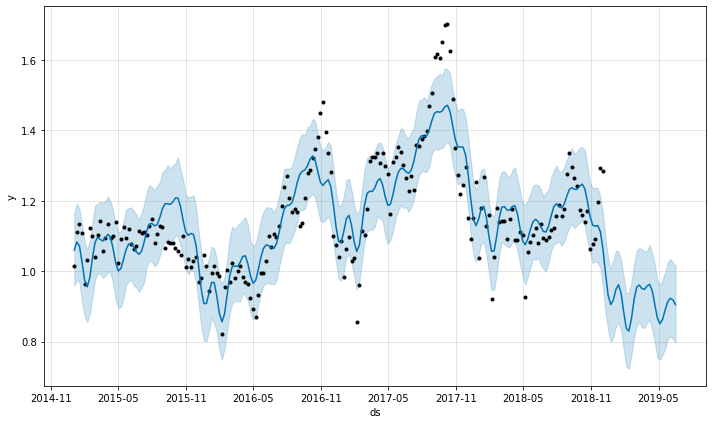

In [35]:
# forecast visualisation
forecast_conv_P_def = model_conv_P_def.predict(future_conv_P_def)
fig_conv_P_def = model_conv_P_def.plot(forecast_conv_P_def)

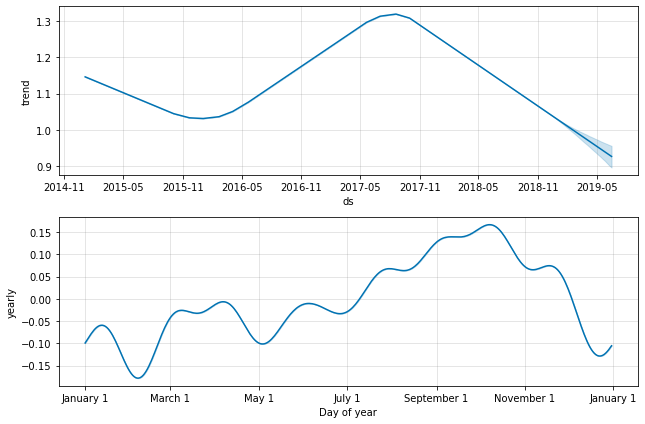

In [36]:
# model components visualisation
fig_conv_P_comp_def = model_conv_P_def.plot_components(forecast_conv_P_def)

In [37]:
# selecting only the test period forecast
pred_conv_P_2019_def = forecast_conv_P_def[forecast_conv_P_def["ds"]>"2019-01-01"][["ds", "yhat"]]

In [38]:
# simplifing the actuals dataframe for comparison
actuals_conv_P_2019_def = prices_US_conv_2019[["Date", "AveragePrice"]]
actuals_conv_P_2019_def.columns = ["ds", "y"]

In [39]:
# merging the prediction and actuals dataframes into one
conv_P_2019_def = actuals_conv_P_2019_def.merge(pred_conv_P_2019_def, on="ds")

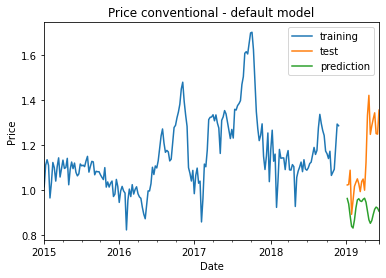

In [45]:
# plotting training, test and prediction data
conv_P_df.set_index("ds")["y"].plot(label="training")
conv_P_2019_def.set_index("ds")["y"].plot(label="test")
conv_P_2019_def.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price conventional - default model")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Price conventional - default model.png")
plt.show()

In [41]:
# Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [42]:
# model's MAPE calculation
model_conv_P_def_MAPE = MAPE(conv_P_2019_def["y"], conv_P_2019_def["yhat"])

In [43]:
print("Default model MAPE: {:.2f}".format(model_conv_P_def_MAPE))

Default model MAPE: 18.27


### Model with hyperparameter tuning 

In [46]:
# cross-validation hyperparameters on the Prophet model
param_grid = {  
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "growth": ["linear", "flat"],
    "daily_seasonality": [False],
    "weekly_seasonality": [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(conv_P_df)  # Fit model with given params
    df_cv_conv_P = cross_validation(m, initial="730 days", period="90 days", horizon="365 days", parallel="processes")
    df_p_conv_P = performance_metrics(df_cv_conv_P, rolling_window=1)
    mapes.append(df_p_conv_P["mape"].values[0])
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mapes
print(tuning_results)

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf5ccf350>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf7abba10>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf7b67450>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf7b72210>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.proc

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  growth  \
0                      0.00                     0.01         additive  linear   
1                      0.00                     0.01         additive    flat   
2                      0.00                     0.01   multiplicative  linear   
3                      0.00                     0.01   multiplicative    flat   
4                      0.00                     0.10         additive  linear   
..                      ...                      ...              ...     ...   
59                     0.50                     1.00   multiplicative    flat   
60                     0.50                    10.00         additive  linear   
61                     0.50                    10.00         additive    flat   
62                     0.50                    10.00   multiplicative  linear   
63                     0.50                    10.00   multiplicative    flat   

    daily_seasonality  week

In [47]:
# selecting the best hyperparameters
best_params_conv_P = all_params[np.argmin(mapes)]
print(best_params_conv_P)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'growth': 'flat', 'daily_seasonality': False, 'weekly_seasonality': False}


In [48]:
# creating the model with the best parameters
model_conv_P = Prophet(**best_params_conv_P)

In [49]:
# fitting the model on the whole training set
model_conv_P.fit(conv_P_df)

In [51]:
future_conv_P = model_conv_P.make_future_dataframe(periods=len(prices_US_conv_2019), freq="W")

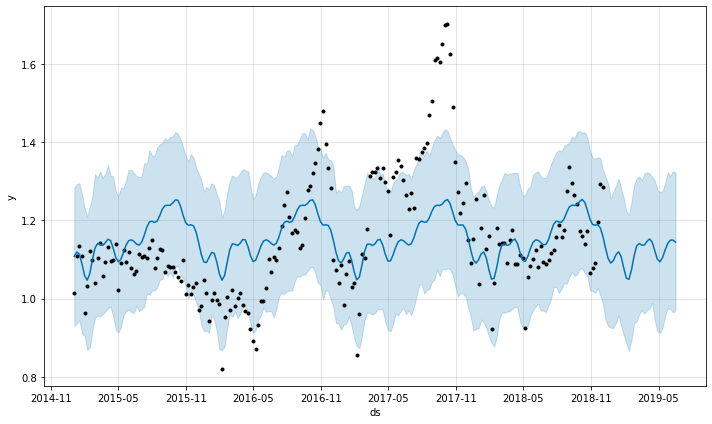

In [52]:
# forecast visualisation
forecast_conv_P = model_conv_P.predict(future_conv_P)
fig_conv_P = model_conv_P.plot(forecast_conv_P)

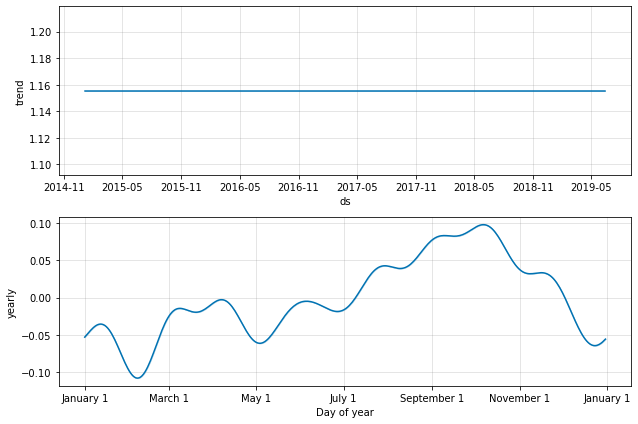

In [53]:
# model components visualisation
fig_conv_P_comp = model_conv_P.plot_components(forecast_conv_P)

In [54]:
# cross-validation of the selected model
df_cv_conv_P = cross_validation(model_conv_P, initial="730 days", period="90 days", horizon="365 days", parallel="processes")

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf829c1d0>


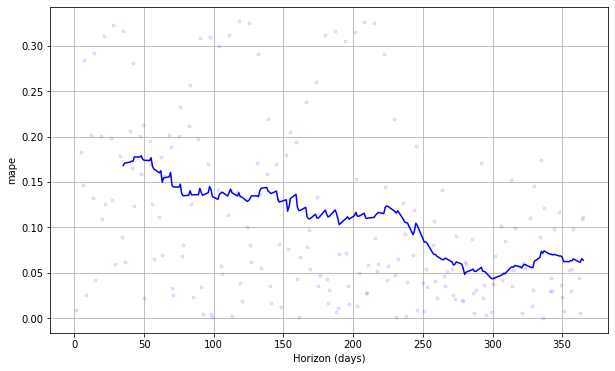

In [55]:
# MAPE of the cross-validated model visualisation
fig_conv_P_cv_mape = plot_cross_validation_metric(df_cv_conv_P, metric='mape')

In [56]:
# selecting only the test period forecast
pred_conv_P_2019 = forecast_conv_P[forecast_conv_P["ds"]>"2019-01-01"][["ds", "yhat"]]

In [57]:
# simplifing the actuals dataframe for comparison
actuals_conv_P_2019 = prices_US_conv_2019[["Date", "AveragePrice"]]
actuals_conv_P_2019.columns = ["ds", "y"]

In [58]:
# merging the prediction and actuals dataframes into one
conv_P_2019 = actuals_conv_P_2019.merge(pred_conv_P_2019, on="ds")

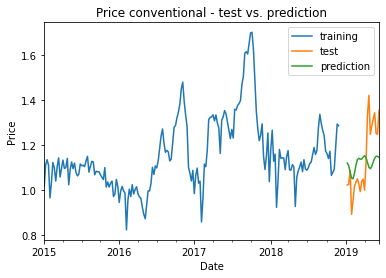

In [59]:
# plotting training, test and prediction data
conv_P_df.set_index("ds")["y"].plot(label="training")
conv_P_2019.set_index("ds")["y"].plot(label="test")
conv_P_2019.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price conventional - test vs. prediction")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Price conventional - test vs. prediction.png")
plt.show()

In [60]:
# model's MAPE calculation
model_conv_P_MAPE = MAPE(conv_P_2019["y"], conv_P_2019["yhat"])

In [61]:
# default vs. tuned models' MAPE
print("Default model MAPE: {:.2f}".format(model_conv_P_def_MAPE))
print("Tuned model MAPE: {:.2f}".format(model_conv_P_MAPE))

Default model MAPE: 18.27
Tuned model MAPE: 11.14


### Forecasting

In [62]:
# simplifing the full dataset for use by Prophet
conv_P_full = prices_US_conv_merged[["Date", "AveragePrice"]]
conv_P_full.columns = ["ds", "y"]

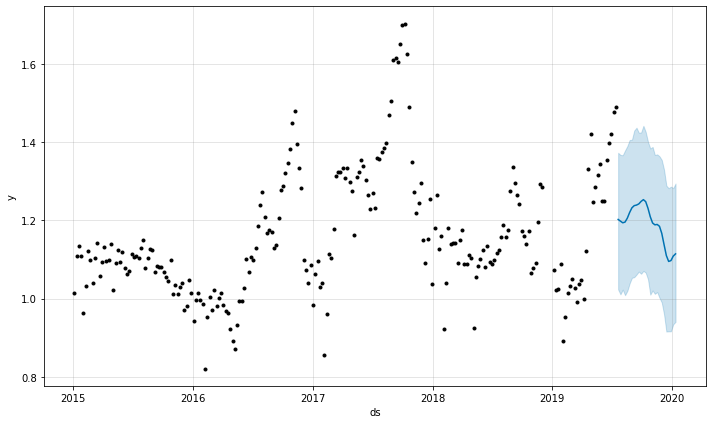

In [63]:
# re-training the model using the best performing parameters and full dataset
# creating 6-month forecast
model_conv_P_for = Prophet(**best_params_conv_P)
model_conv_P_for.fit(conv_P_full)
future_6m_conv_P = model_conv_P_for.make_future_dataframe(periods=26, freq="W", include_history=False)
forecast_6m_conv_P = model_conv_P_for.predict(future_6m_conv_P)
fig_6m_conv_P = model_conv_P_for.plot(forecast_6m_conv_P)

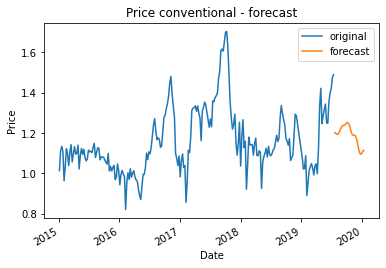

In [64]:
# plotting forecast
conv_P_full.set_index("ds")["y"].plot(label="original")
forecast_6m_conv_P.set_index("ds")["yhat"].plot(label="forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price conventional - forecast")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Price conventional - forecast.png")
plt.show()

## Model for price of organic type

In [65]:
# simplifing the dataframe for use by Prophet
org_P_df = prices_US_org_2015_2018[["Date", "AveragePrice"]]
org_P_df.columns = ["ds", "y"]

### Default model

In [66]:
# creating model with default values, skipping only the daily and weekly seasonality which isn't present in our data
model_org_P_def = Prophet(daily_seasonality=False, weekly_seasonality=False)

In [67]:
# fitting the model on the whole training set
model_org_P_def.fit(org_P_df)

In [68]:
future_org_P_def = model_org_P_def.make_future_dataframe(periods=len(prices_US_org_2019), freq="W")

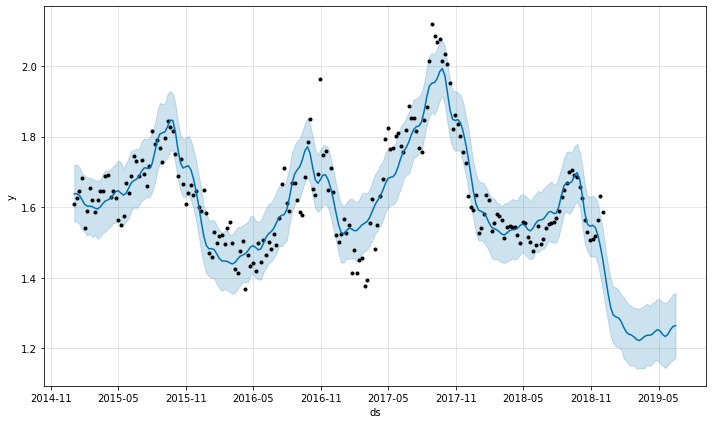

In [69]:
# forecast visualisation
forecast_org_P_def = model_org_P_def.predict(future_org_P_def)
fig_org_P_def = model_org_P_def.plot(forecast_org_P_def)

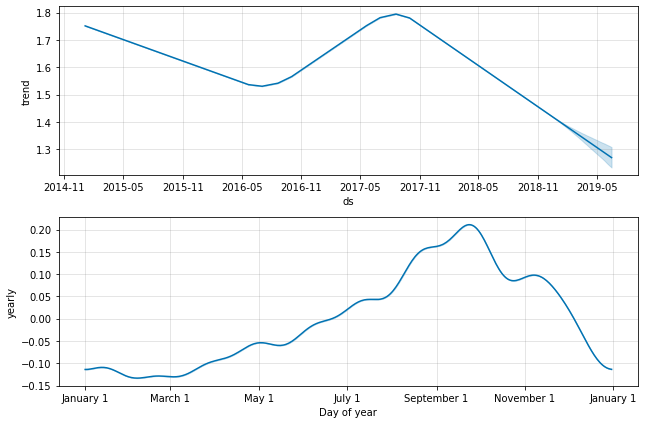

In [70]:
# model components visualisation
fig_org_P_comp_def = model_org_P_def.plot_components(forecast_org_P_def)

In [71]:
# selecting only the test period forecast
pred_org_P_2019_def = forecast_org_P_def[forecast_org_P_def["ds"]>"2019-01-01"][["ds", "yhat"]]

In [72]:
# simplifing the actuals dataframe for comparison
actuals_org_P_2019_def = prices_US_org_2019[["Date", "AveragePrice"]]
actuals_org_P_2019_def.columns = ["ds", "y"]

In [73]:
# merging the prediction and actuals dataframes into one
org_P_2019_def = actuals_org_P_2019_def.merge(pred_org_P_2019_def, on="ds")

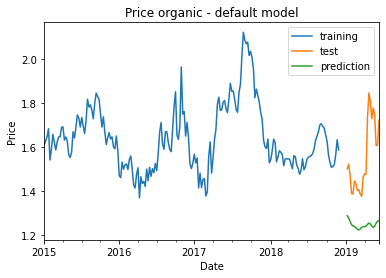

In [74]:
# plotting training, test and prediction data
org_P_df.set_index("ds")["y"].plot(label="training")
org_P_2019_def.set_index("ds")["y"].plot(label="test")
org_P_2019_def.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price organic - default model")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Price organic - default model.png")
plt.show()

In [75]:
# model's MAPE calculation
model_org_P_def_MAPE = MAPE(org_P_2019_def["y"], org_P_2019_def["yhat"])

In [76]:
print("Default model MAPE: {:.2f}".format(model_org_P_def_MAPE))

Default model MAPE: 19.01


### Model with hyperparameter tuning

In [77]:
# cross-validation hyperparameters on the Prophet model
param_grid = {  
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "growth": ["linear", "flat"],
    "daily_seasonality": [False],
    "weekly_seasonality": [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(org_P_df)  # Fit model with given params
    df_cv_org_P = cross_validation(m, initial="730 days", period="90 days", horizon="365 days", parallel="processes")
    df_p_org_P = performance_metrics(df_cv_org_P, rolling_window=1)
    mapes.append(df_p_org_P["mape"].values[0])
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mapes
print(tuning_results)

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf624a1d0>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd84ab650>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf59fec50>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf5314ad0>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.proc

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  growth  \
0                      0.00                     0.01         additive  linear   
1                      0.00                     0.01         additive    flat   
2                      0.00                     0.01   multiplicative  linear   
3                      0.00                     0.01   multiplicative    flat   
4                      0.00                     0.10         additive  linear   
..                      ...                      ...              ...     ...   
59                     0.50                     1.00   multiplicative    flat   
60                     0.50                    10.00         additive  linear   
61                     0.50                    10.00         additive    flat   
62                     0.50                    10.00   multiplicative  linear   
63                     0.50                    10.00   multiplicative    flat   

    daily_seasonality  week

In [78]:
# selecting the best hyperparameters
best_params_org_P = all_params[np.argmin(mapes)]
print(best_params_org_P)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'growth': 'flat', 'daily_seasonality': False, 'weekly_seasonality': False}


In [79]:
# creating the model with the best parameters
model_org_P = Prophet(**best_params_org_P)

In [80]:
# fitting the model on the whole training set
model_org_P.fit(org_P_df)

In [81]:
len(prices_US_org_2019)

28

In [82]:
future_org_P = model_org_P.make_future_dataframe(periods=len(prices_US_org_2019), freq="W")

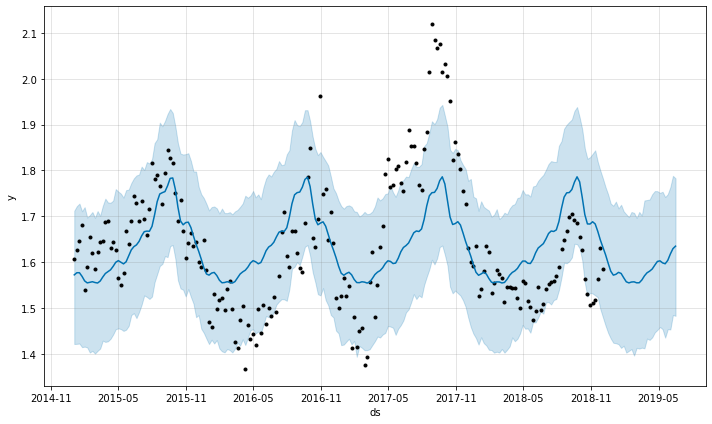

In [83]:
# forecast visualisation
forecast_org_P = model_org_P.predict(future_org_P)
fig_org_P = model_org_P.plot(forecast_org_P)

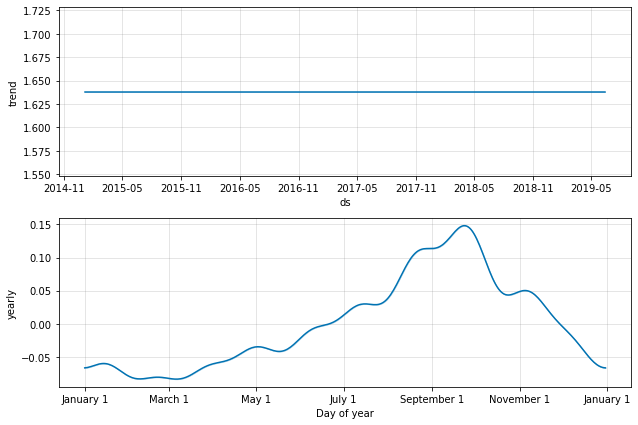

In [84]:
# model components visualisation
fig_org_P_comp = model_org_P.plot_components(forecast_org_P)

In [85]:
# cross-validation of the selected model
df_cv_org_P = cross_validation(model_org_P, initial="730 days", period="90 days", horizon="365 days", parallel="processes")

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf6189e50>


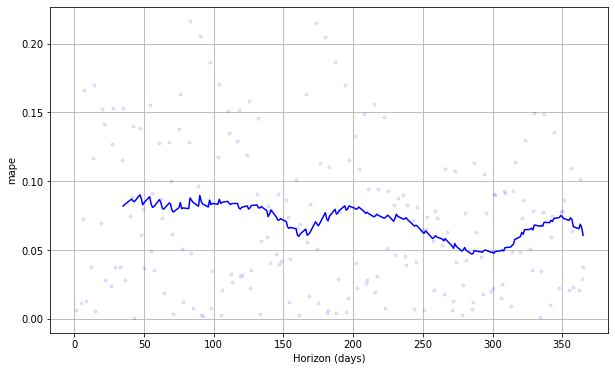

In [86]:
# MAPE of the cross-validated model visualisation
fig_org_P_cv_mape = plot_cross_validation_metric(df_cv_org_P, metric='mape')

In [87]:
# selecting only the test period forecast
pred_org_P_2019 = forecast_org_P[forecast_org_P["ds"]>"2019-01-01"][["ds", "yhat"]]

In [88]:
# simplifing the actuals dataframe for comparison
actuals_org_P_2019 = prices_US_org_2019[["Date", "AveragePrice"]]
actuals_org_P_2019.columns = ["ds", "y"]

In [89]:
# merging the prediction and actuals dataframes into one
org_P_2019 = actuals_org_P_2019.merge(pred_org_P_2019, on="ds")

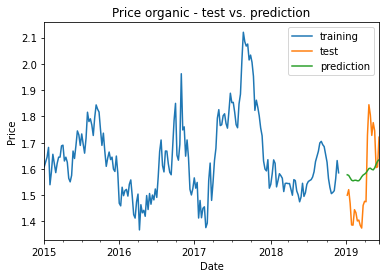

In [90]:
# plotting training, test and prediction data
org_P_df.set_index("ds")["y"].plot(label="training")
org_P_2019.set_index("ds")["y"].plot(label="test")
org_P_2019.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price organic - test vs. prediction")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Price organic - test vs. prediction.png")
plt.show()

In [91]:
# model's MAPE calculation
model_org_P_MAPE = MAPE(org_P_2019["y"], org_P_2019["yhat"])

In [92]:
# default vs. tuned models' MAPE
print("Default model MAPE: {:.2f}".format(model_org_P_def_MAPE))
print("Tuned model MAPE: {:.2f}".format(model_org_P_MAPE))

Default model MAPE: 19.01
Tuned model MAPE: 8.35


### Forecasting

In [93]:
# simplifing the full dataset for use by Prophet
org_P_full = prices_US_org_merged[["Date", "AveragePrice"]]
org_P_full.columns = ["ds", "y"]

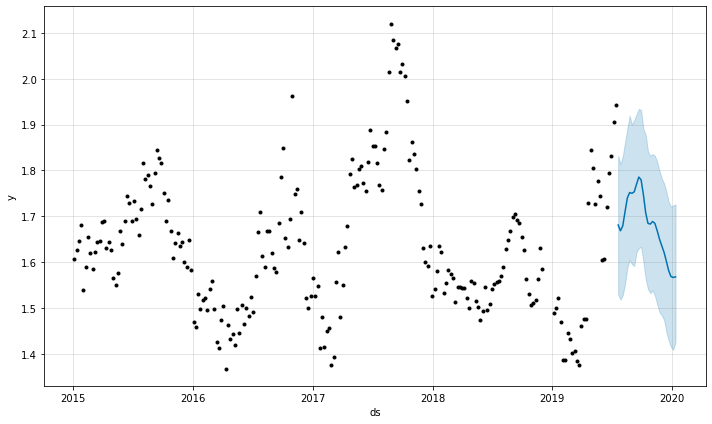

In [94]:
# re-training the model using the best performing parameters and full dataset
# creating 6-month (= 26-week) forecast
model_org_P_for = Prophet(**best_params_org_P)
model_org_P_for.fit(org_P_full)
future_6m_org_P = model_org_P_for.make_future_dataframe(periods=26, freq="W", include_history=False)
forecast_6m_org_P = model_org_P_for.predict(future_6m_org_P)
fig_6m_org_P = model_org_P_for.plot(forecast_6m_org_P)

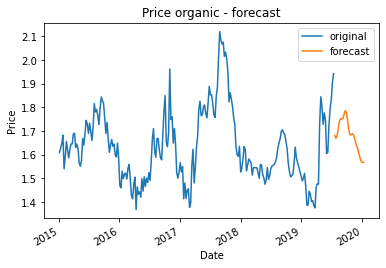

In [95]:
# plotting forecast
org_P_full.set_index("ds")["y"].plot(label="original")
forecast_6m_org_P.set_index("ds")["yhat"].plot(label="forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price organic - forecast")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Price organic - forecast.png")
plt.show()

## Model for volume of conventional type

In [96]:
# simplifing the dataframe for use by Prophet
conv_Q_df = prices_US_conv_2015_2018[["Date", "TotalVolume"]]
conv_Q_df.columns = ["ds", "y"]

# conv_Q_df["cap"] 

### Default model

In [97]:
# creating model with default values, skipping only the daily and weekly seasonality which isn't present in our data
model_conv_Q_def = Prophet(daily_seasonality=False, weekly_seasonality=False)

In [98]:
# fitting the model on the whole training set
model_conv_Q_def.fit(conv_Q_df)

In [99]:
future_conv_Q_def = model_conv_Q_def.make_future_dataframe(periods=len(prices_US_conv_2019), freq="W")

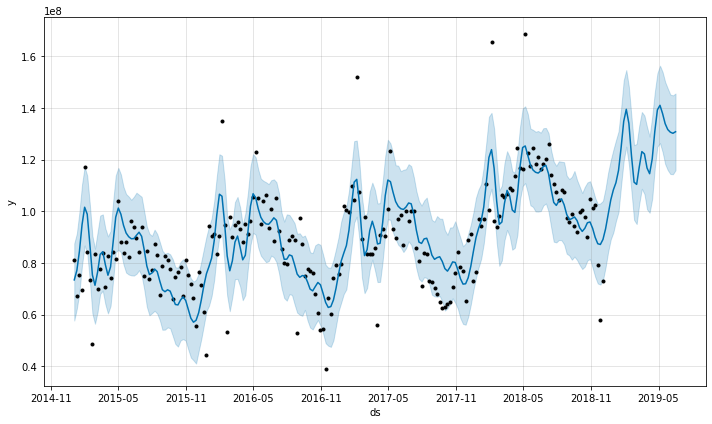

In [100]:
# forecast visualisation
forecast_conv_Q_def = model_conv_Q_def.predict(future_conv_Q_def)
fig_conv_Q_def = model_conv_Q_def.plot(forecast_conv_Q_def)

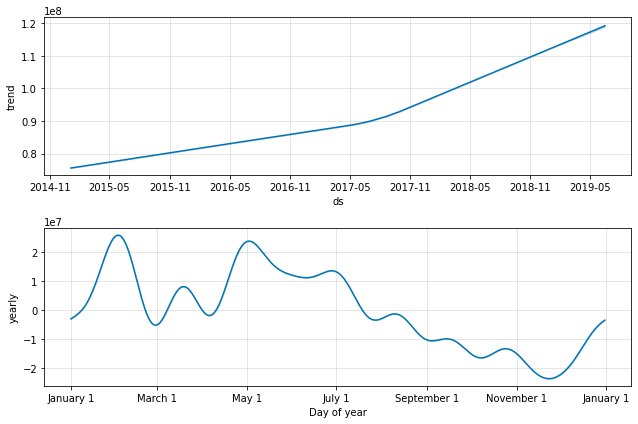

In [101]:
# model components visualisation
fig_conv_Q_comp_def = model_conv_Q_def.plot_components(forecast_conv_Q_def)

In [102]:
# selecting only the test period forecast
pred_conv_Q_2019_def = forecast_conv_Q_def[forecast_conv_Q_def["ds"]>"2019-01-01"][["ds", "yhat"]]

In [103]:
# simplifing the actuals dataframe for comparison
actuals_conv_Q_2019_def = prices_US_conv_2019[["Date", "TotalVolume"]]
actuals_conv_Q_2019_def.columns = ["ds", "y"]

In [104]:
# merging the prediction and actuals dataframes into one
conv_Q_2019_def = actuals_conv_Q_2019_def.merge(pred_conv_Q_2019_def, on="ds")

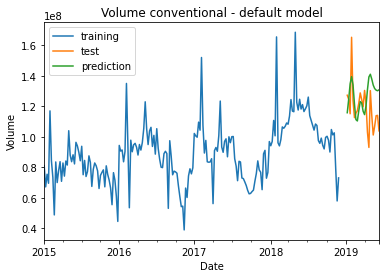

In [105]:
# plotting training, test and prediction data
conv_Q_df.set_index("ds")["y"].plot(label="training")
conv_Q_2019_def.set_index("ds")["y"].plot(label="test")
conv_Q_2019_def.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume conventional - default model")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Volume conventional - default model.png")
plt.show()

In [106]:
# model's MAPE calculation
model_conv_Q_def_MAPE = MAPE(conv_Q_2019_def["y"], conv_Q_2019_def["yhat"])

In [107]:
print("Default model MAPE: {:.2f}".format(model_conv_Q_def_MAPE))

Default model MAPE: 13.46


### Model with hyperparameter tuning

In [108]:
# cross-validation hyperparameters on the Prophet model
param_grid = {  
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "growth": ["linear", "flat"], # "logistic" might be better for this model but we'd need the cap value estimate from the client
    "seasonality_mode": ["additive", "multiplicative"],
    "daily_seasonality": [False],
    "weekly_seasonality": [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters

for params in all_params:
    m = Prophet(**params).fit(conv_Q_df)  # Fit model with given params
    df_cv_conv_Q = cross_validation(m, initial="730 days", period="90 days", horizon="365 days", parallel="processes")
    df_p_conv_Q = performance_metrics(df_cv_conv_Q, rolling_window=1)
    mapes.append(df_p_conv_Q["mape"].values[0])
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mapes
print(tuning_results)

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf7ae46d0>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd8e46110>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd97418d0>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcf5800050>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.proc

    changepoint_prior_scale  seasonality_prior_scale  growth seasonality_mode  \
0                      0.00                     0.01  linear         additive   
1                      0.00                     0.01  linear   multiplicative   
2                      0.00                     0.01    flat         additive   
3                      0.00                     0.01    flat   multiplicative   
4                      0.00                     0.10  linear         additive   
..                      ...                      ...     ...              ...   
59                     0.50                     1.00    flat   multiplicative   
60                     0.50                    10.00  linear         additive   
61                     0.50                    10.00  linear   multiplicative   
62                     0.50                    10.00    flat         additive   
63                     0.50                    10.00    flat   multiplicative   

    daily_seasonality  week

In [109]:
# selecting the best hyperparameters
best_params_conv_Q = all_params[np.argmin(mapes)]
print(best_params_conv_Q)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'daily_seasonality': False, 'weekly_seasonality': False}


In [110]:
# creating the model with the best parameters
model_conv_Q = Prophet(**best_params_conv_Q)

In [111]:
# fitting the model on the whole training set
model_conv_Q.fit(conv_Q_df)

In [112]:
future_conv_Q = model_conv_Q.make_future_dataframe(periods=len(prices_US_conv_2019), freq="W")

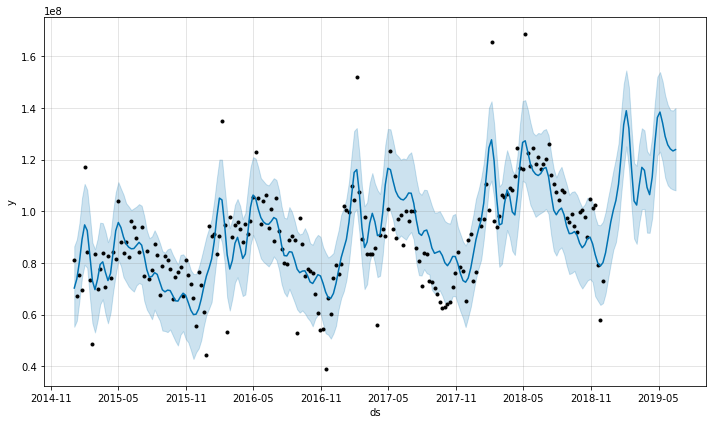

In [113]:
# forecast visualisation
forecast_conv_Q = model_conv_Q.predict(future_conv_Q)
fig_conv_Q = model_conv_Q.plot(forecast_conv_Q)

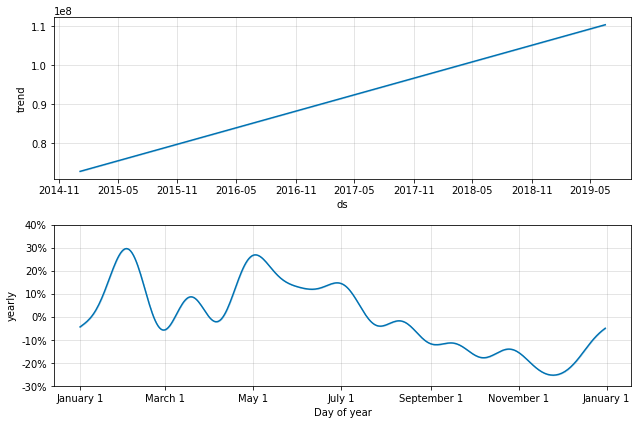

In [114]:
# model components visualisation
fig_conv_Q_comp = model_conv_Q.plot_components(forecast_conv_Q)

In [115]:
# cross-validation of the selected model
df_cv_conv_Q = cross_validation(model_conv_Q, initial="730 days", period="90 days", horizon="365 days", parallel="processes")

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcdaa397d0>


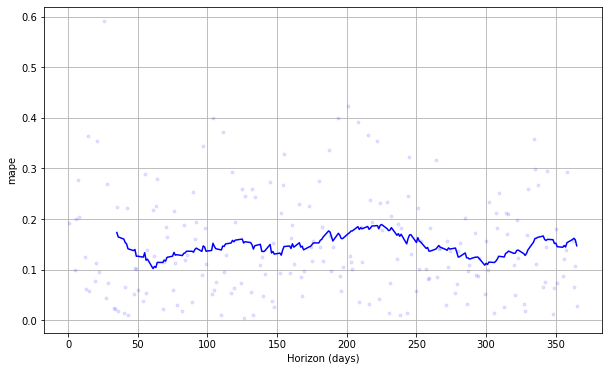

In [116]:
# MAPE of the cross-validated model visualisation
fig_conv_Q_cv_mape = plot_cross_validation_metric(df_cv_conv_Q, metric='mape')

In [117]:
# selecting only the test period forecast
pred_conv_Q_2019 = forecast_conv_Q[forecast_conv_Q["ds"]>"2019-01-01"][["ds", "yhat"]]

In [118]:
# simplifing the actuals dataframe for comparison
actuals_conv_Q_2019 = prices_US_conv_2019[["Date", "TotalVolume"]]
actuals_conv_Q_2019.columns = ["ds", "y"]

In [119]:
# merging the prediction and actuals dataframes into one
conv_Q_2019 = actuals_conv_Q_2019.merge(pred_conv_Q_2019, on="ds")

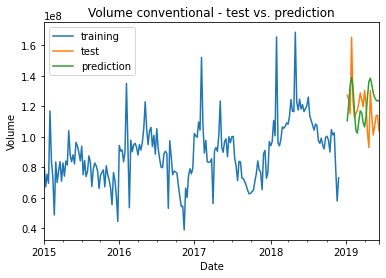

In [120]:
# plotting training, test and prediction data
conv_Q_df.set_index("ds")["y"].plot(label="training")
conv_Q_2019.set_index("ds")["y"].plot(label="test")
conv_Q_2019.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume conventional - test vs. prediction")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Volume conventional - test vs. prediction.png")
plt.show()

In [121]:
# model's MAPE calculation
model_conv_Q_MAPE = MAPE(conv_Q_2019["y"], conv_Q_2019["yhat"])

In [122]:
# default vs. tuned models' MAPE
print("Default model MAPE: {:.2f}".format(model_conv_Q_def_MAPE))
print("Tuned model MAPE: {:.2f}".format(model_conv_Q_MAPE))

Default model MAPE: 13.46
Tuned model MAPE: 13.70


### Forecasting

In [123]:
# simplifing the full dataset for use by Prophet
conv_Q_full = prices_US_conv_merged[["Date", "TotalVolume"]]
conv_Q_full.columns = ["ds", "y"]

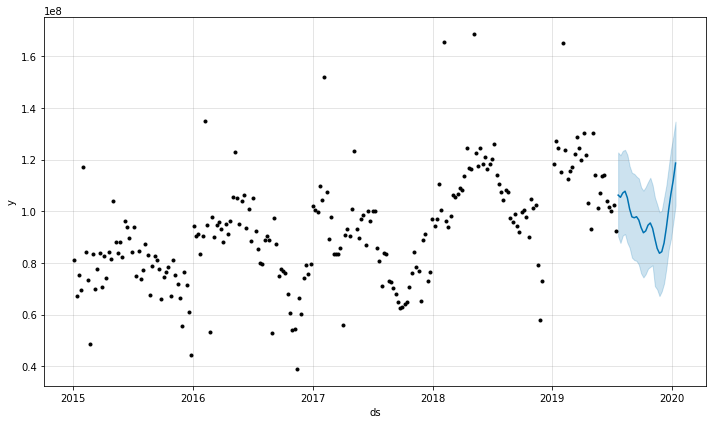

In [124]:
# re-training the model using the best performing parameters and full dataset
# creating 6-month (= 26-week) forecast
model_conv_Q_for = Prophet(**best_params_conv_Q)
model_conv_Q_for.fit(conv_Q_full)
future_6m_conv_Q = model_conv_Q_for.make_future_dataframe(periods=26, freq="W", include_history=False)
forecast_6m_conv_Q = model_conv_Q_for.predict(future_6m_conv_Q)
fig_6m_conv_Q = model_conv_Q_for.plot(forecast_6m_conv_Q)

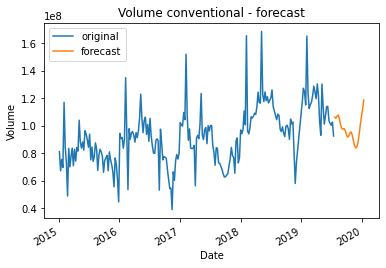

In [125]:
# plotting forecast
conv_Q_full.set_index("ds")["y"].plot(label="original")
forecast_6m_conv_Q.set_index("ds")["yhat"].plot(label="forecast")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume conventional - forecast")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Volume conventional - forecast.png")
plt.show()

## Model for volume of organic type

In [126]:
# simplifing the dataframe for use by Prophet
org_Q_df = prices_US_org_2015_2018[["Date", "TotalVolume"]]
org_Q_df.columns = ["ds", "y"]

# org_Q_df["cap"] 

### Default model

In [127]:
# creating model with default values, skipping only the daily and weekly seasonality which isn't present in our data
model_org_Q_def = Prophet(daily_seasonality=False, weekly_seasonality=False)

In [128]:
# fitting the model on the whole training set
model_org_Q_def.fit(org_Q_df)

In [129]:
future_org_Q_def = model_org_Q_def.make_future_dataframe(periods=len(prices_US_org_2019), freq="W")

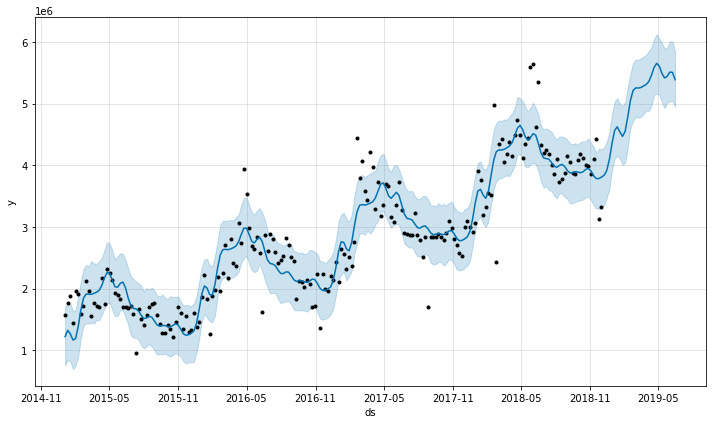

In [130]:
# forecast visualisation
forecast_org_Q_def = model_org_Q_def.predict(future_org_Q_def)
fig_org_Q_def = model_org_Q_def.plot(forecast_org_Q_def)

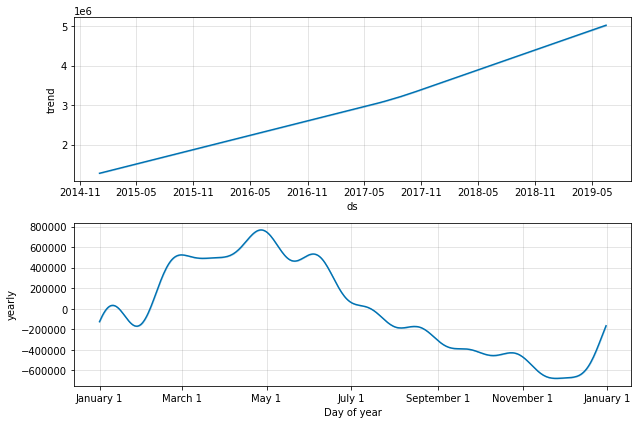

In [131]:
# model components visualisation
fig_org_Q_comp_def = model_org_Q_def.plot_components(forecast_org_Q_def)

In [132]:
# selecting only the test period forecast
pred_org_Q_2019_def = forecast_org_Q_def[forecast_org_Q_def["ds"]>"2019-01-01"][["ds", "yhat"]]

In [133]:
# simplifing the actuals dataframe for comparison
actuals_org_Q_2019_def = prices_US_org_2019[["Date", "TotalVolume"]]
actuals_org_Q_2019_def.columns = ["ds", "y"]

In [134]:
# merging the prediction and actuals dataframes into one
org_Q_2019_def = actuals_org_Q_2019_def.merge(pred_org_Q_2019_def, on="ds")

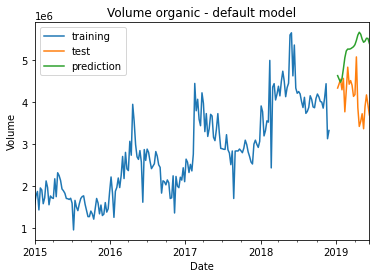

In [135]:
# plotting training, test and prediction data
org_Q_df.set_index("ds")["y"].plot(label="training")
org_Q_2019_def.set_index("ds")["y"].plot(label="test")
org_Q_2019_def.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume organic - default model")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Volume organic - default model.png")
plt.show()

In [136]:
# model's MAPE calculation
model_org_Q_def_MAPE = MAPE(org_Q_2019_def["y"], org_Q_2019_def["yhat"])

In [137]:
print("Default model MAPE: {:.2f}".format(model_org_Q_def_MAPE))

Default model MAPE: 27.94


### Model with hyperparameter tuning

In [138]:
# cross-validation hyperparameters on the Prophet model
param_grid = {  
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "growth": ["linear", "flat"], # "logistic" might be better for this model but we'd need the cap value estimate from the client
    "seasonality_mode": ["additive", "multiplicative"],
    "daily_seasonality": [False],
    "weekly_seasonality": [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters

for params in all_params:
    m = Prophet(**params).fit(org_Q_df)  # Fit model with given params
    df_cv_org_Q = cross_validation(m, initial="730 days", period="90 days", horizon="365 days", parallel="processes")
    df_p_org_Q = performance_metrics(df_cv_org_Q, rolling_window=1)
    mapes.append(df_p_org_Q["mape"].values[0])
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mapes
print(tuning_results)

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd9cbf210>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd9cd7c90>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd9cd7a10>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcdbc95310>
INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.proc

    changepoint_prior_scale  seasonality_prior_scale  growth seasonality_mode  \
0                      0.00                     0.01  linear         additive   
1                      0.00                     0.01  linear   multiplicative   
2                      0.00                     0.01    flat         additive   
3                      0.00                     0.01    flat   multiplicative   
4                      0.00                     0.10  linear         additive   
..                      ...                      ...     ...              ...   
59                     0.50                     1.00    flat   multiplicative   
60                     0.50                    10.00  linear         additive   
61                     0.50                    10.00  linear   multiplicative   
62                     0.50                    10.00    flat         additive   
63                     0.50                    10.00    flat   multiplicative   

    daily_seasonality  week

In [139]:
# selecting the best hyperparameters
best_params_org_Q = all_params[np.argmin(mapes)]
print(best_params_org_Q)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'growth': 'linear', 'seasonality_mode': 'additive', 'daily_seasonality': False, 'weekly_seasonality': False}


In [140]:
# creating the model with the best parameters
model_org_Q = Prophet(**best_params_org_Q)

In [141]:
# fitting the model on the whole training set
model_org_Q.fit(org_Q_df)

In [142]:
future_org_Q = model_org_Q.make_future_dataframe(periods=len(prices_US_org_2019), freq="W")

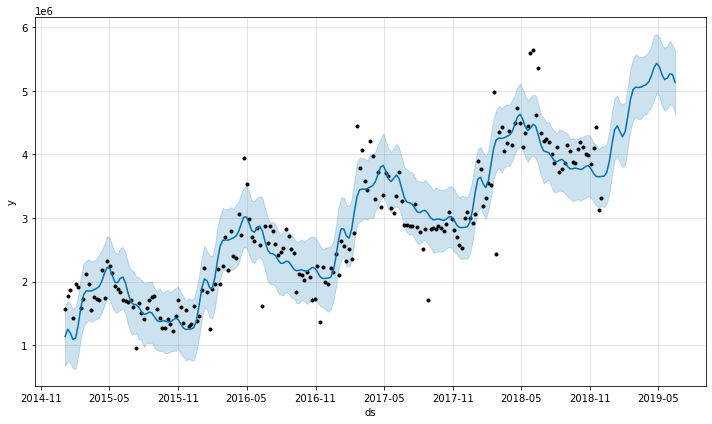

In [143]:
# forecast visualisation
forecast_org_Q = model_org_Q.predict(future_org_Q)
fig_org_Q = model_org_Q.plot(forecast_org_Q)

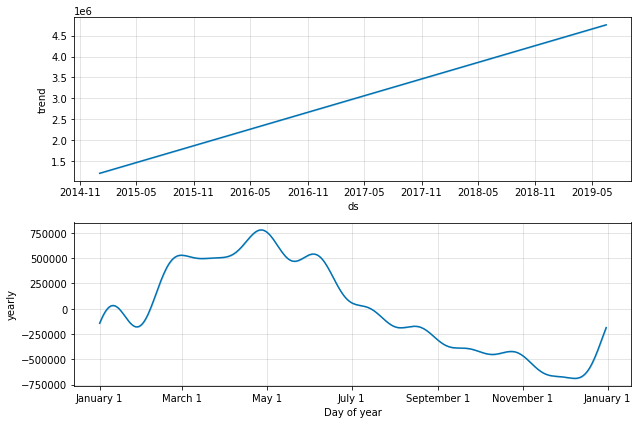

In [144]:
# model components visualisation
fig_org_Q_comp = model_org_Q.plot_components(forecast_org_Q)

In [145]:
# cross-validation of the selected model
df_cv_org_Q = cross_validation(model_org_Q, initial="730 days", period="90 days", horizon="365 days", parallel="processes")

INFO:prophet:Making 4 forecasts with cutoffs between 2017-03-07 00:00:00 and 2017-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdcd8ec8b50>


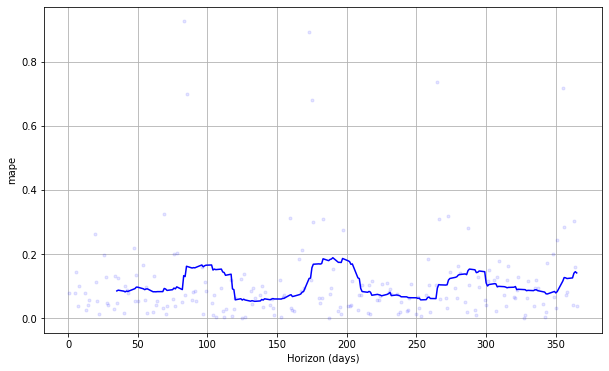

In [146]:
# MAPE of the cross-validated model visualisation
fig_org_Q_cv_mape = plot_cross_validation_metric(df_cv_org_Q, metric='mape')

In [147]:
# selecting only the test period forecast
pred_org_Q_2019 = forecast_org_Q[forecast_org_Q["ds"]>"2019-01-01"][["ds", "yhat"]]

In [148]:
# simplifing the actuals dataframe for comparison
actuals_org_Q_2019 = prices_US_org_2019[["Date", "TotalVolume"]]
actuals_org_Q_2019.columns = ["ds", "y"]

In [149]:
# merging the prediction and actuals dataframes into one
org_Q_2019 = actuals_org_Q_2019.merge(pred_org_Q_2019, on="ds")

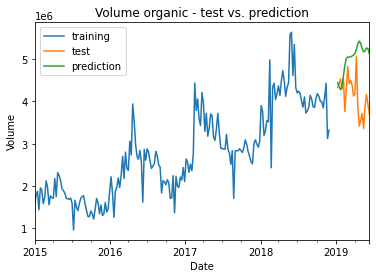

In [150]:
# plotting training, test and prediction data
org_Q_df.set_index("ds")["y"].plot(label="training")
org_Q_2019.set_index("ds")["y"].plot(label="test")
org_Q_2019.set_index("ds")["yhat"].plot(label="prediction")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume organic - test vs. prediction")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Volume organic - test vs. prediction.png")
plt.show()

In [151]:
# model's MAPE calculation
model_org_Q_MAPE = MAPE(org_Q_2019["y"], org_Q_2019["yhat"])

In [152]:
# default vs. tuned models' MAPE
print("Default model MAPE: {:.2f}".format(model_org_Q_def_MAPE))
print("Tuned model MAPE: {:.2f}".format(model_org_Q_MAPE))

Default model MAPE: 27.94
Tuned model MAPE: 23.18


### Forecasting

In [153]:
# simplifing the full dataset for use by Prophet
org_Q_full = prices_US_org_merged[["Date", "TotalVolume"]]
org_Q_full.columns = ["ds", "y"]

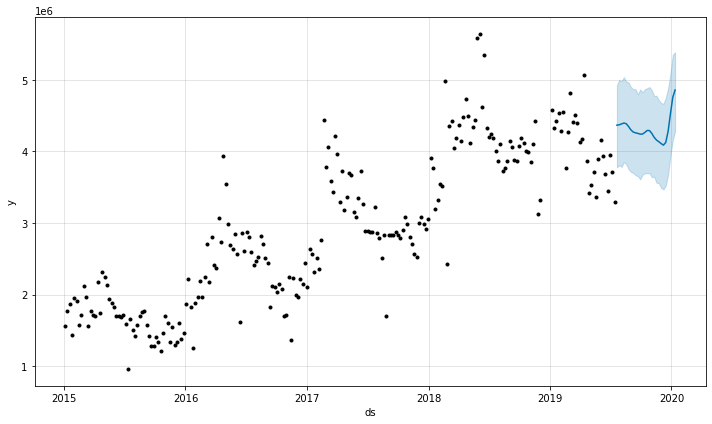

In [154]:
# re-training the model using the best performing parameters and full dataset
# creating 6-month (= 26-week) forecast
model_org_Q_for = Prophet(**best_params_org_Q)
model_org_Q_for.fit(org_Q_full)
future_6m_org_Q = model_org_Q_for.make_future_dataframe(periods=26, freq="W", include_history=False)
forecast_6m_org_Q = model_org_Q_for.predict(future_6m_org_Q)
fig_6m_org_Q = model_org_Q_for.plot(forecast_6m_org_Q)

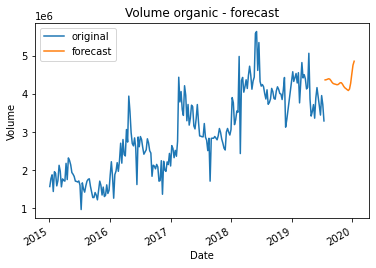

In [155]:
# plotting forecast
org_Q_full.set_index("ds")["y"].plot(label="original")
forecast_6m_org_Q.set_index("ds")["yhat"].plot(label="forecast")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume organic - forecast")
plt.legend()
plt.savefig(str(constants.OUTPUTS_DIR) + "/Volume organic - forecast.png")
plt.show()